## **CONVOLUTIONAL NEURAL NETWORK --> BINARY CLASSIFICATION**

This notebook consists of training a convolutional neural network with two kinds of images:

- One showing broken concrete

- Other showing unbroken concrete

The neural network, once trained, will be able to classify these two types of images as broken or unbroken, using 0 and 1.

### Packages

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
os.getcwd()

'/workspaces/Deep_Learning'

### Image Preprocessing

In [4]:
transform = transforms.Compose(
    [transforms.Resize(32),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 4
trainset = torchvision.datasets.ImageFolder(root='060_CNN_ImageClassification/BinaryClassification/data/train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = torchvision.datasets.ImageFolder(root='060_CNN_ImageClassification/BinaryClassification/data/test', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)
classes = ['Positive', 'Negative']

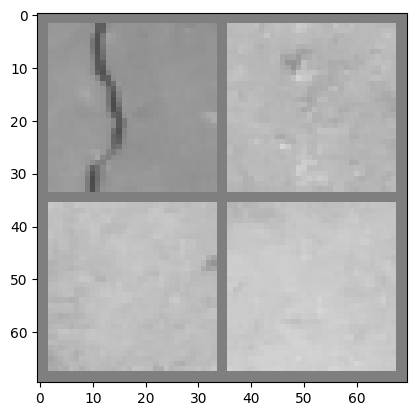

In [5]:
def imshow(img):
    img = img / 2 + 0.5 #unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


#get some random training images
for images, labels in trainloader:
    imshow(torchvision.utils.make_grid(images, nrow=2))
    break

### Neural Network Setup

In [6]:
class ImageClassificationNet(nn.Module): #base class for all PyTorch models
    def __init__(self) -> None: #none indicates that the method does not return any explicit value
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3) #first conv layer, 1 input channel, 6 output channels and a 3x3 kernel size
        self.pool = nn.MaxPool2d(2, 2) #maximum clustering with 2x2 window size and 2 pixel offset
        self.conv2 = nn.Conv2d(6, 16, 3) #second conv layer, 6 input channel, 16 output channels and a 3x3 kernel size
        self.fc1 = nn.Linear(16 * 6 * 6, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1) #fully connected (or dense) layers to perform classification
        self.relu = nn.ReLU() #activation function (Rectified Linear Unit), which is used after the convolutional layers and fully connected
        self.sigmoid = nn.Sigmoid() #sigmoid trigger function, which is used to obtain the final output of the network in the range 0 to 1
    
    def forward(self, x): #defines how data is propagated through the network, x represents the input data (images)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

- Convolutional and pooling layers are applied using the functions self.conv1, self.pool, self.conv2 and self.pool
- After each convolutional layer, a ReLU activation function is applied via F.relu(x), where F is the alias for the torch.nn.functional module
- Before moving from convolutional layers to fully connected layers, the data is flattened into a one-dimensional vector using torch.flatten
- The fully connected layers (self.fc1, self.fc2, self.fc3) and the activation functions ReLU (self.relu) and sigmoid (self.sigmoid) are applied in sequence to obtain the final network output.

- In a binary classification problem, the output of the neural network is passed through a sigmoid function to be interpreted as the probability that the input belongs to one of the two classes

### Model

In [7]:
model = ImageClassificationNet()      
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.8)

- Training

In [11]:
NUM_EPOCHS = 10
for epoch in range(NUM_EPOCHS):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = loss_fn(outputs, labels.reshape(-1, 1).float()) #two dimesinal
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f'Epoch {epoch}/{NUM_EPOCHS}, Step {i+1}/{len(trainloader)},'
                  f'Loss: {loss.item():.4f}')

Epoch 0/10, Step 1/250,Loss: 0.0608
Epoch 0/10, Step 101/250,Loss: 0.1023
Epoch 0/10, Step 201/250,Loss: 0.7515
Epoch 1/10, Step 1/250,Loss: 0.0891
Epoch 1/10, Step 101/250,Loss: 0.6243
Epoch 1/10, Step 201/250,Loss: 0.0671
Epoch 2/10, Step 1/250,Loss: 0.0736
Epoch 2/10, Step 101/250,Loss: 0.4583
Epoch 2/10, Step 201/250,Loss: 0.0283
Epoch 3/10, Step 1/250,Loss: 0.7380
Epoch 3/10, Step 101/250,Loss: 0.1140
Epoch 3/10, Step 201/250,Loss: 0.0634
Epoch 4/10, Step 1/250,Loss: 0.5227
Epoch 4/10, Step 101/250,Loss: 0.6602
Epoch 4/10, Step 201/250,Loss: 0.0453
Epoch 5/10, Step 1/250,Loss: 0.1249
Epoch 5/10, Step 101/250,Loss: 0.3962
Epoch 5/10, Step 201/250,Loss: 0.1331
Epoch 6/10, Step 1/250,Loss: 0.5995
Epoch 6/10, Step 101/250,Loss: 0.0834
Epoch 6/10, Step 201/250,Loss: 0.0865
Epoch 7/10, Step 1/250,Loss: 0.5752
Epoch 7/10, Step 101/250,Loss: 0.0910
Epoch 7/10, Step 201/250,Loss: 0.0740
Epoch 8/10, Step 1/250,Loss: 0.0395
Epoch 8/10, Step 101/250,Loss: 0.0213
Epoch 8/10, Step 201/250,Loss:

- Testing

In [12]:
y_test = []
y_test_pred = []
for i, data in enumerate(testloader, 0):
    inputs, y_test_temp = data
    with torch.no_grad():
        y_test_hat_temp = model(inputs).round()
    
    y_test.extend(y_test_temp.numpy())
    y_test_pred.extend(y_test_hat_temp.numpy())

- Accuracy

In [13]:
acc = accuracy_score(y_test, y_test_pred)
print(f'Accuracy: {acc*100:.2f} %')

Accuracy: 89.83 %


-----------